**Import modules and set paths.**

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
## make paths above 'notebooks/' visible for local imports.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd 
from scipy.sparse import coo_matrix
# from scipy.linalg import lstsq
print(f"using numpy v{np.__version__}.")
print(f"using pandas v{pd.__version__}.")

import matplotlib
import matplotlib.pyplot as plt

from ipywidgets import interact

from lininvbox.lininvbox.equation import Term
from lininvbox.lininvbox.constructors import *
from lininvbox.lininvbox.operations import *
from lininvbox.lininvbox.inversion import Inversion
from lininvbox.lininvbox.constraints import *
from lininvbox.lininvbox.regularisation import *
from magscales.magscales import Richter1958
from plotconf import matsettings


using numpy v1.19.4.
using pandas v1.1.5.


/opt/anaconda3/envs/YPML/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


## Yellowstone National Park $M_L$ Non-Paramatric Inversion
### A notebook to perform a non-parametric inversion to recover $M_L$, distance and station corrections using earthquakes from Yellowstone Nation Park.



In [2]:
PDIR = ".."
for_inv = pd.read_csv(f"{PDIR}/catalogs/amplitudes/yellowstone.amps.clean.geobalanced.csv")
sims = pd.read_csv(f"{PDIR}/miscmeta/simulations/data/sim_out.csv")

In [3]:
interp_nodes = np.array([1, 10, 30, 50, 100, 180])
inc = np.geomspace(4, 180, 20)
dr = 5
inc = np.arange(20, 180+dr, dr)
interp_nodes = np.round(np.append([6,9,12,15,18,21], inc[inc>=25]), 1)
# interp_nodes=inc
interp_values = np.sort(for_inv.Rhyp.values)

mwcat = pd.read_csv("../catalogs/events/MTCAT.csv")
mwcat["Evid"] = mwcat["Evid"].astype(str)
MLcons = dict(mwcat[["Evid", "MwPref"]].values)


In [4]:
def vis_inv_output(inv):

    terms = inv.m.term_map.values.keys()
    X, Y = [],[]
    for term in terms:
        tmp = inv.m.term_map.get_term(term)
        if term == "MLi":
            X.append(tmp['unique_indices'])
        else:
            X.append(tmp['unique_labels'])
        Y.append(tmp['model_values'])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for ax, y, x, term in zip(axes, Y, X, terms):
        ax.plot(x, y, 'ks', mfc='none')
        ax.set_ylabel(term)
        if term == "Sj":
            ax.tick_params(axis='x', labelrotation = 90)
            
    return fig, axes

def vis_matrices(mats, kind='spy', **kwargs):

    fs = (4.5*2, 15)
    
    if type(mats) is list:
        assert type(mats[0]) is coo_matrix or type(mats[0]) is np.ndarray,\
        f"Matrices in list must be coo_matrix or np.ndarray not {type(mats[0])}."

        fig, axes = plt.subplots(1, num_mats, figsize=fs)
    else:
        fig, axes = plt.subplots(1, 1, figsize=fs)
        axes = [axes,]
        mats = [mats,]

    for mat, ax in zip(mats, axes):

        # spy plot
        if kind == 'spy':
            ax.spy(mat, aspect='auto', **kwargs)
        # matshot
        if kind == 'matshow':
            a = ax.matshow(mat.toarray(), aspect='auto', **kwargs)
            fig.colorbar(a)

    fig.tight_layout()
    
    return fig, axes



In [5]:
stas = for_inv[["Net", "Sta"]].agg('.'.join, axis=1).values
evs = for_inv['Evid'].apply(str).values

In [6]:
logA0np = Term("logA0n", "LINEAR INTERPOLATION", for_inv.Rhyp.values, unique_labels=interp_nodes)
MLp = Term("MLi", "CONSTANT", evs)
Sjp = Term("Sj", "CONSTANT", stas, sign=-1)

In [7]:
logA0n = LinInterpCoeffs(logA0np) 
MLi = ConstantCoeffs(MLp)
Sj = ConstantCoeffs(Sjp)
G = logA0n + MLi + Sj
d = DataArray(for_inv['halfAmpH'].apply(np.log10))

In [8]:
inv = Inversion("YPML")

In [9]:
inv.invert(G, d)

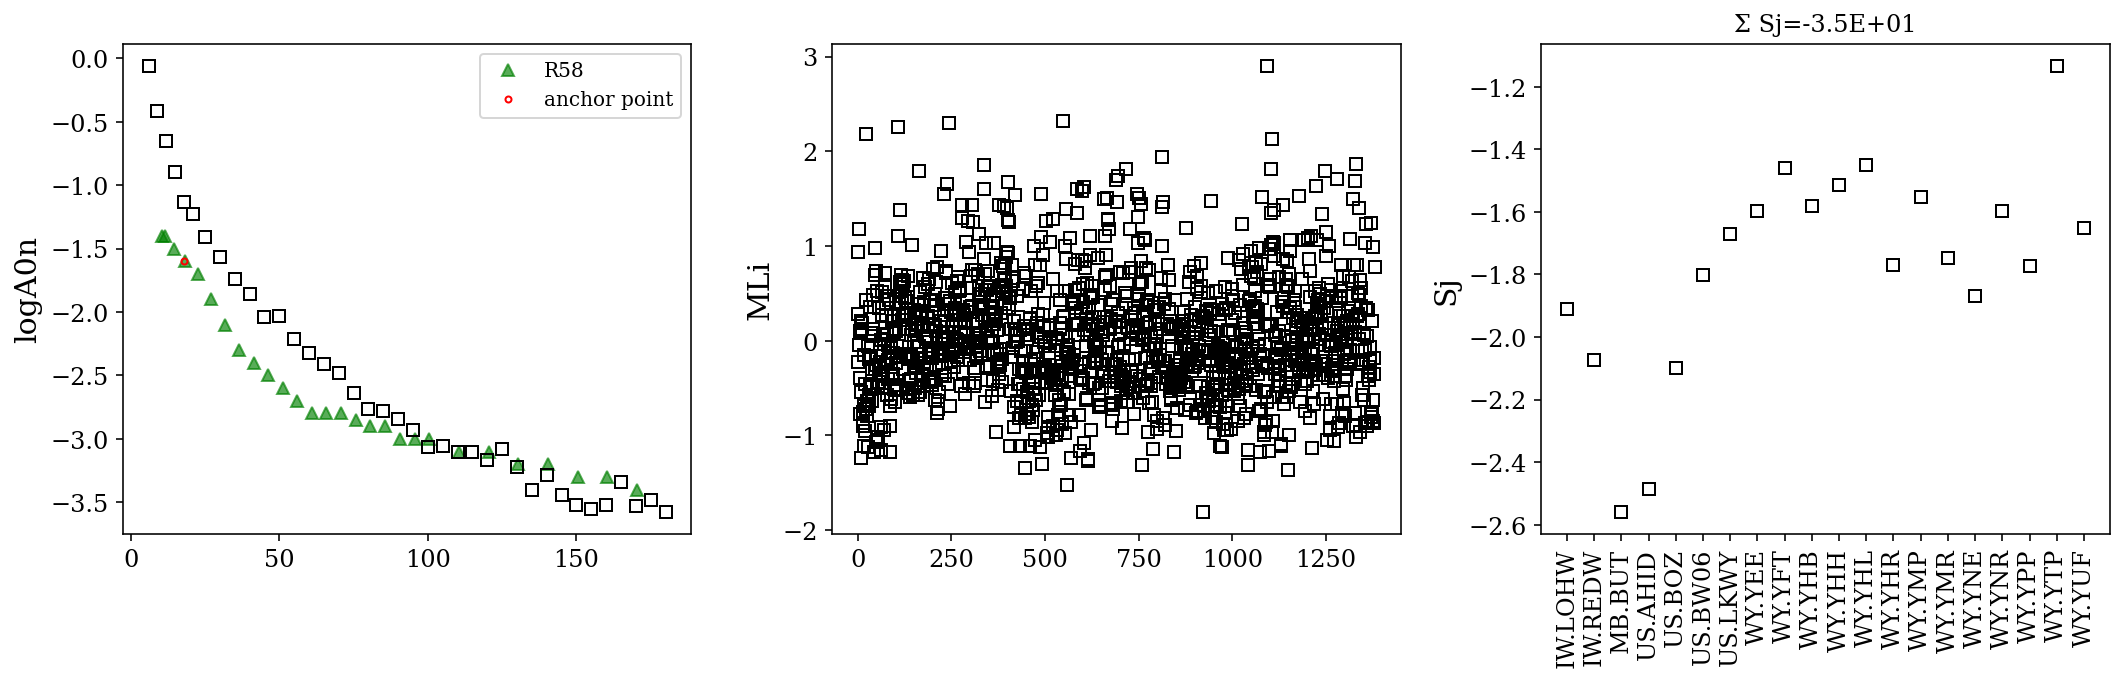

In [10]:
r = Richter1958()
r.epi_to_hypo(av_dep=10.5)
fig, axes = vis_inv_output(inv)
axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
axes[0].legend()
axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
fig.tight_layout()
# axes[0].set_xscale("log")

## Smoothing parameter ($\alpha$) penalty tests

To smooth our inversions we use the Thikonov formality ()

### Roughness vs MSE
In the first set of tests we show the roughness ($||\dfrac{\mathrm{d^2}logA_{0}(R)}{\mathrm{d}R^2}||^2$) by the mean error  of the resdiuals between predicted and recorded data (MSE). 

In [11]:
inv = Inversion("YPML")
alphas = np.geomspace(1E-1, 20, 40)

def regularisation_optimiser(inv, G, d, alphas, constraints=None):
    
    _rough = np.zeros(len(alphas))
    _mse = np.zeros(len(alphas))

    for i in range(len(alphas)):
        MSE, ROUGH = reg_test_invert(inv, G, d, alphas[i], constraints)
        _mse[i] = MSE
        _rough[i] = ROUGH

    # point of maximum curvature on L-curve is the optimal value for alpha   
    pt = np.abs(np.diff(np.log10(_rough), 2)).argmin() 
                                       
    return _mse, _rough, pt
                                       
def reg_test_invert(inv, G, d, alpha, constraints):
    Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alpha)))
    m = inv.invert(G, d, regularisation=Gamma, constraints=constraints, inplace=False)
    fd = inv.forward(G, m)    
    _mse = mse(d.array.A.flatten(), fd.array.A.flatten())
    inds = m.term_map.values["logA0n"]['model_indices']
    _rough = roughness(m.array.A[inds].flatten())
    
    return _mse, _rough

try:
    _mse = np.load(f".norm/mse.npy")
    _rough = np.load(f".norm/rough.npy")
    best_i = np.load(f".norm/besti.npy")
    print("loaded local files")
except FileNotFoundError:
    _mse, _rough, best_i = regularisation_optimiser(inv, G, d, alphas)
    os.makedirs(".norm", exist_ok=True)
    np.save(f".norm/mse.npy", _mse)
    np.save(f".norm/rough.npy", _rough)
    np.save(f".norm/besti.npy", best_i)
print(f"Best alpha is {alphas[best_i]:.2f}.")

loaded local files
Best alpha is 5.14.


We obtain an "L-curve" and choose the value for alpha at the point of maximum curvature (2nd derivative is minimum).

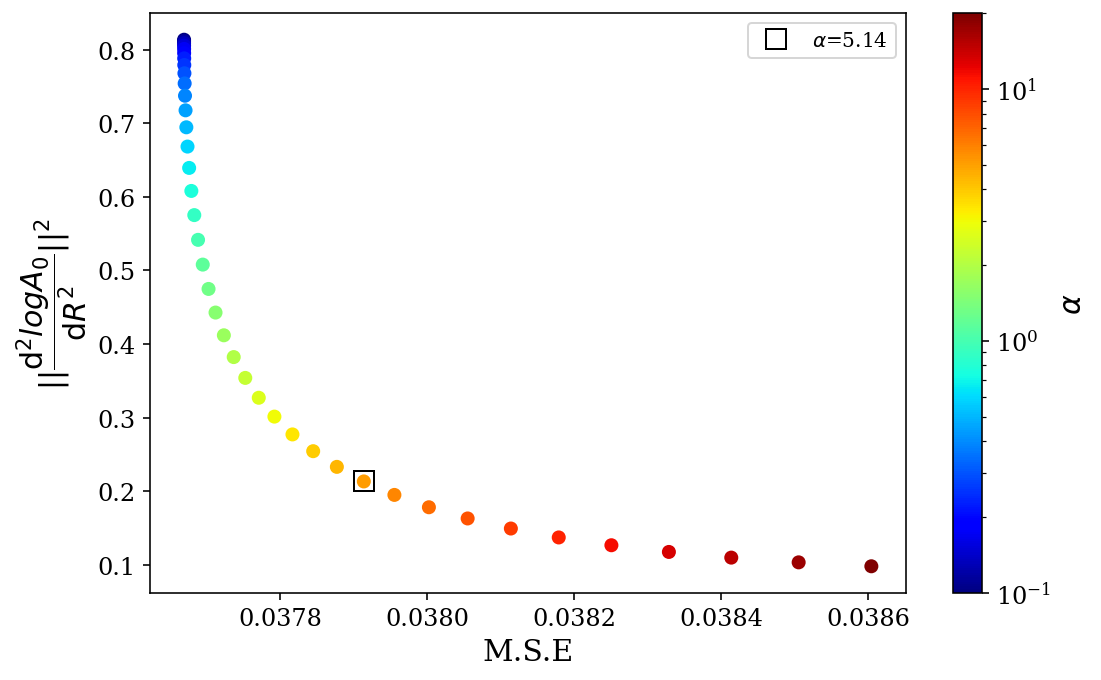

In [12]:
def plot_regularisation_optimiser(mse, rough, alphas, best_i, save=""):

    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    out = ax.scatter(mse, rough, c=alphas, cmap="jet", norm=matplotlib.cm.colors.LogNorm()) 
    ax.plot(mse[best_i], rough[best_i], 'ks', ms=10, mfc='none', label=r"$\alpha$={:.2f}".format(alphas[best_i]))
    ax.set_xlabel("M.S.E")
    ax.set_ylabel(r"$||\dfrac{\mathrm{d^2}logA_{0}}{\mathrm{d}R^2}||^2$") 
    ax.legend()
    fig.tight_layout()
    fig.colorbar(out, label=r"$\alpha$")
    if save:
        fig.savefig(save)
        
plot_regularisation_optimiser(_mse, _rough, alphas, best_i)

Visulise the effect on changing $\alpha$ on the recovered model.

In [13]:
C =  Constraints(G.term_map, OrderedDict(Sj={"SUM":0},))
              
@interact
def alpha_vis(alpha=np.round(np.geomspace(1E-1, 20, 40), 2)):
    
    global C
    
    Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=alpha)))
    inv = Inversion("YPML")
    inv.invert(G, d, constraints=C, regularisation=Gamma)

    r = Richter1958()
    r.epi_to_hypo(av_dep=10.5)
    fig, axes = vis_inv_output(inv)
    axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
    axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
    axes[0].legend()
    axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
    fig.tight_layout()

interactive(children=(Dropdown(description='alpha', options=(0.1, 0.11, 0.13, 0.15, 0.17, 0.2, 0.23, 0.26, 0.3…

Visualise the effect of arbitrary constraints on the recovered model.

In [14]:
c1 = OrderedDict(#logA0n={18:-1.6}, 
                   Sj={"SUM":0},)
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
#                    MLi=MLcons)
c2 = OrderedDict(logA0n={18:-1.6}, 
                   Sj={"SUM":0},)
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
#                    MLi=MLcons)

c3 = OrderedDict(#logA0n={18:-1.6}, 
                   Sj={"SUM":0},
#                    Sj={"SUM":0, "MB.BUT":-0.23, #"US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
                   MLi=MLcons)

c4 = OrderedDict(logA0n={18:-1.6}, 
                   Sj={"SUM":0},
#                    Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43}, 
#                        "US.BOZ":0.17}, #"US.BW06":-0.15},)
                   MLi=MLcons)

c5 = OrderedDict(logA0n={18:-1.6}, 
#                    Sj={"SUM":0},
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43,
                       "US.BOZ":0.17, "US.BW06":-0.15},)
#                    MLi=MLcons)

c6 = OrderedDict(logA0n={18:-1.6}, 
#                    Sj={"SUM":0},
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43,
                       "US.BOZ":0.17, "US.BW06":-0.15},
                   MLi=MLcons)

c7 = OrderedDict(#logA0n={18:-1.6}, 
#                    Sj={"SUM":0},)
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43, 
                       "US.BOZ":0.17, "US.BW06":-0.15},
                   MLi=MLcons)

c8 = OrderedDict(#logA0n={18:-1.6}, 
#                    Sj={"SUM":0},)
                   Sj={"SUM":0, "MB.BUT":-0.23, "US.AHID":-0.43, 
                       "US.BOZ":0.17, "US.BW06":-0.15},)
#                    MLi=MLcons)

cons = [c1, c2, c3, c4, c5, c6, c7, c8]
Cs = [None]+[Constraints(G.term_map, constraints=con) for con in cons]

@interact
def constraints_vis(C=Cs, A=-np.round(np.arange(0.3, 1.1, 0.1), 1)):

    inv = Inversion("YPML")
    Gamma = Regularisation(G.term_map, regs=OrderedDict(logA0n=dict(kind="FD", alpha=5.14)))
    inv.invert(G, d, regularisation=Gamma, constraints=C)

    r = Richter1958()
    r.epi_to_hypo(av_dep=10.5)
    fig, axes = vis_inv_output(inv)
    axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
    axes[0].hist2d(sims.rhyp, sims.A+A, bins=(30,25), cmap="gnuplot", norm=matplotlib.cm.colors.LogNorm(),)
    axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
    axes[0].legend()
    axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
    axes[2].plot(["MB.BUT", "US.AHID", "US.BOZ", "US.BW06"], [-0.23, -0.43, 0.17, -0.15], 'ro', label='UUSS')
    axes[2].legend()
    fig.tight_layout()

interactive(children=(Dropdown(description='C', options=(None, Fixed... Sj SUM Sj, Fixed... logA0nSj SUM Sj, F…

### Station-amplitude-distance distributions

Can we speculate which stations we might expect a significant bias by looking at the KDE's of the distance distributions?

In [15]:
@interact
def plot_sta_kdes(Sta=for_inv.Sta.unique(), d=["Rhyp", "Repi"]):
    plt.figure(figsize=(12, 7))
    out = for_inv.groupby("Sta")[d].plot.kde(logx=True)
    plt.xlim([5, 250])
    plt.xlabel(d)
    for_inv[for_inv.Sta.isin([Sta,])].groupby("Sta")[d].plot.kde(color='k', lw=5)

interactive(children=(Dropdown(description='Sta', options=('AHID', 'LKWY', 'BUT', 'YMR', 'BOZ', 'YFT', 'BW06',…

In [16]:
# r = Richter1958()
# r.epi_to_hypo(av_dep=10.5)
# fig, axes = vis_inv_output(inv)
# axes[0].hist2d(sims.rhyp, sims.A-0.8, bins=(30,25), cmap="gnuplot", norm=matplotlib.cm.colors.LogNorm(),)

# # axes[0].plot(r.distances[r.distances<=180], r.logA0[r.distances<=180], 'g^', label="R58", zorder=1, alpha=0.65)
# axes[0].plot(18, -1.6, 'r.', mfc='none', label="anchor point")
# axes[0].set_xlim([0, 185])
# axes[0].legend()
# axes[2].set_title(f"\u03A3 Sj={np.sum(G.term_map.get_term('Sj')['model_values']):.1E}")
# fig.tight_layout()